# Prepping the notebook

## Mount drive and Import data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_path = '/content/drive/MyDrive/AIML-Great Learning/Neural Network/Plants_photos/train'
prediction_img = '/content/drive/MyDrive/AIML-Great Learning/Neural Network/Plants_photos/predict_plant.png'

## Importing all the required libraries

In [ ]:
import os

import math
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

from glob import glob
import tensorflow as tf
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, Conv2D
from keras.applications.vgg16 import VGG16
from keras.applications import resnet

from sklearn import svm
from sklearn.model_selection import GridSearchCV
from skimage.transform import resize
from skimage.io import imread
from sklearn.model_selection import train_test_split

## Explore the training data

In [ ]:
# Let's find the number of plant classes we have and what are the species
plant_species = os.listdir(data_path)
print('Total number of plant species :',len(plant_species))
print('The different plant species are :', plant_species)


Total number of plant species : 12
The different plant species are : ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


In [ ]:
c=0
for img in plant_species:
    print("Total images of '{img}' seedling is: {count}"
          .format(img = img, count = len(os.listdir(data_path+'/'+img))))
    c=c+len(os.listdir(data_path+'/'+img))

print("Total Number of Images:", c)

Total images of 'Black-grass' seedling is: 263
Total images of 'Charlock' seedling is: 390
Total images of 'Cleavers' seedling is: 287
Total images of 'Common Chickweed' seedling is: 611
Total images of 'Common wheat' seedling is: 221
Total images of 'Fat Hen' seedling is: 475
Total images of 'Loose Silky-bent' seedling is: 671
Total images of 'Maize' seedling is: 221
Total images of 'Scentless Mayweed' seedling is: 516
Total images of 'Shepherds Purse' seedling is: 231
Total images of 'Small-flowered Cranesbill' seedling is: 496
Total images of 'Sugar beet' seedling is: 385
Total Number of Images: 4767


## Visualizing few images

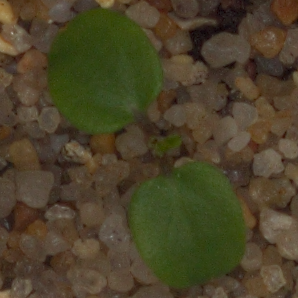

In [ ]:
#Load an image using Keras image class
image_file = data_path + '/Cleavers/01605ed73.png'
cleaver_image = tf.keras.preprocessing.image.load_img(image_file)
cleaver_image

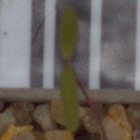

In [ ]:
#Load an image using Keras image class
image_file = data_path + '/Fat Hen/00268e97d.png'
fathen_image = tf.keras.preprocessing.image.load_img(image_file)
fathen_image

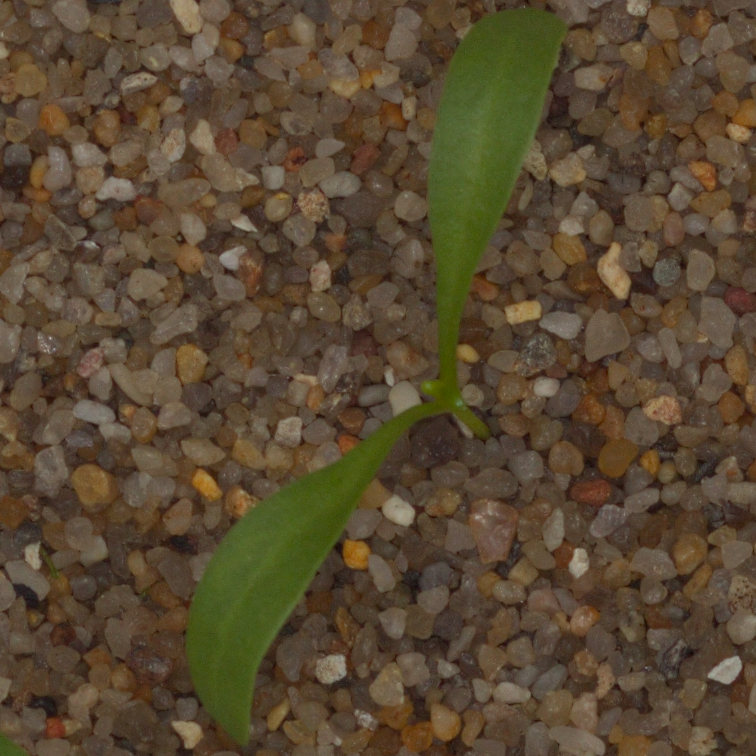

In [ ]:
#Load an image using Keras image class
image_file = data_path + '/Sugar beet/0026b7a30.png'
sugar_beet_image = tf.keras.preprocessing.image.load_img(image_file)
sugar_beet_image

In [ ]:
#Size of the image
cleaver_image.size

(298, 298)

In [ ]:
#Size of the image
fathen_image.size

(140, 140)

In [ ]:
#Size of the image
sugar_beet_image.size

(756, 756)

### Analysis
1. There are 12 categories of plant specied to be classified
2. The image sizes vary for each image and needs to be resized to same dimensions.

# Fully Connected Dense Model

In [ ]:
# Defining few constants
img_size = 64
input_shape=(64,64,3)
num_classes=12

In [ ]:
#ImageDataGenerator declaration with 20% data as test (80% for training)
img_generator= tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                               width_shift_range=0.2,
                                                               height_shift_range=0.2,
                                                               horizontal_flip=True,
                                                               rescale = 1./255,
                                                               validation_split=0.2)

In [ ]:
#Build training generator. 
train_generator = img_generator.flow_from_directory(data_path,
                                                    target_size=(img_size, img_size),
                                                    subset='training',
                                                    batch_size=64)

#Build test generator
test_generator = img_generator.flow_from_directory(data_path,
                                                   target_size=(img_size, img_size),                                                   
                                                   subset='validation',
                                                   batch_size=64)

Found 3816 images belonging to 12 classes.
Found 951 images belonging to 12 classes.


In [ ]:
#Lets check the features (images) and Labels (flower class) returned by ImageDataGenerator
X, y = next(train_generator)

print('Input features shape', X.shape)
print('Actual labels shape', y.shape)

Input features shape (64, 64, 64, 3)
Actual labels shape (64, 12)


## Dense Model Building

In [ ]:
#Clear any previous model from memory
tf.keras.backend.clear_session()

#Initialize model
model_dense = tf.keras.models.Sequential()

#Add Dense Layers after flattening the data
model_dense.add(tf.keras.layers.Flatten(input_shape=input_shape))
model_dense.add(tf.keras.layers.Dense(1024, activation='relu'))

#normalize data
model_dense.add(tf.keras.layers.BatchNormalization())

#Add another Dense Layer
model_dense.add(tf.keras.layers.Dense(256, activation='relu'))

#Add Dropout
model_dense.add(tf.keras.layers.Dropout(0.25))

#Add another Dense Layer
model_dense.add(tf.keras.layers.Dense(64, activation='relu'))

#Add Output Layer
model_dense.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

## Dense Model Summary and Compilation

In [ ]:
#Model Summary
model_dense.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 12288)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              12583936  
_________________________________________________________________
batch_normalization (BatchNo (None, 1024)              4096      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_3 (Dense)              (None, 12)                7

In [ ]:
# Defining optimizer paramters and compiling the model
opt = optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.001, amsgrad=False)
model_dense.compile(optimizer = opt, loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Early Stopping and Checkpoint

In [ ]:
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
# Stop training if no improvement after some epochs
earlystopper1 = EarlyStopping(monitor='loss', patience=10, verbose=1)

# Save the best model during the traning
checkpointer1 = ModelCheckpoint('plants_dense.h5',
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                save_weights_only=True)

## Training the dense model

In [ ]:
# Running the model for few more epochs to get more stability and better accuracy
history1 = model_dense.fit(train_generator,
                            epochs = 20,
                            steps_per_epoch = 3816//64,  #Number of training images//batch_size
                            validation_data = test_generator,
                            validation_steps = 951//64, #Number of test images//batch_size
                            callbacks = [earlystopper1, checkpointer1])

Epoch 1/20
59/59 [==============================] - 70s 1s/step - loss: 2.3428 - accuracy: 0.2167 - val_loss: 2.5396 - val_accuracy: 0.1283

Epoch 00001: val_accuracy improved from -inf to 0.12835, saving model to plants_dense.h5
Epoch 2/20
59/59 [==============================] - 68s 1s/step - loss: 2.0144 - accuracy: 0.2921 - val_loss: 2.8170 - val_accuracy: 0.1484

Epoch 00002: val_accuracy improved from 0.12835 to 0.14844, saving model to plants_dense.h5
Epoch 3/20
59/59 [==============================] - 69s 1s/step - loss: 1.9088 - accuracy: 0.3246 - val_loss: 2.1126 - val_accuracy: 0.2254

Epoch 00003: val_accuracy improved from 0.14844 to 0.22545, saving model to plants_dense.h5
Epoch 4/20
59/59 [==============================] - 68s 1s/step - loss: 1.8412 - accuracy: 0.3430 - val_loss: 2.5932 - val_accuracy: 0.1752

Epoch 00004: val_accuracy did not improve from 0.22545
Epoch 5/20
59/59 [==============================] - 67s 1s/step - loss: 1.7658 - accuracy: 0.3715 - val_loss

## Dense Model : Loss and Accuracy versus Epoch plot

In [ ]:
print('Best validation ccuracy from Dense Model :', round(max(history1.history['accuracy'])*100,2))

Best validation ccuracy from Dense Model : 46.0


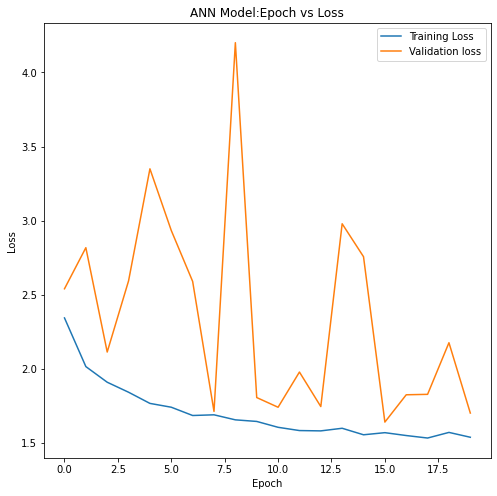

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)

plt.plot(history1.history['loss'], label="Training Loss")
plt.plot(history1.history['val_loss'], label="Validation loss")
plt.title('ANN Model:Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

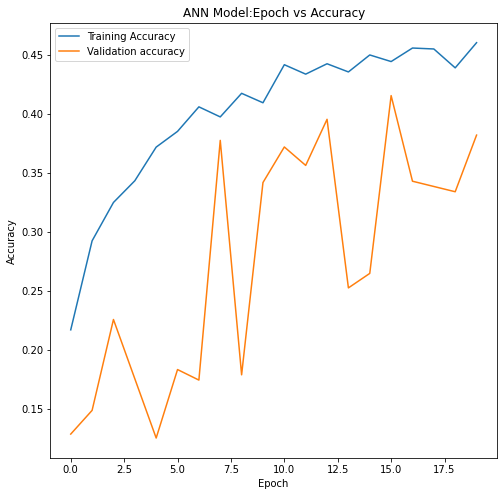

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)

plt.plot(history1.history['accuracy'], label="Training Accuracy")
plt.plot(history1.history['val_accuracy'], label="Validation accuracy")
plt.title('ANN Model:Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

## Dense Model Analysis

Analysis:
1. The model did not converge quite well with the limited 20 number of epochs
2. The model training accuracy was as low as 45%
3. The model validation accuracy was as low as 40%

# CNN Model without Transfer Learning

## CNN Model Building

In [ ]:
#Clear any previous model from memory
tf.keras.backend.clear_session()

#Initialize model
model_cnn = tf.keras.models.Sequential()

#Add Conv Layer
model_cnn.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu',input_shape=input_shape))

#normalize data
model_cnn.add(tf.keras.layers.BatchNormalization())

#Add Conv Layer
model_cnn.add(tf.keras.layers.Conv2D(32, kernel_size=(3,3), activation='relu'))

#normalize data
model_cnn.add(tf.keras.layers.BatchNormalization())

#Add Max Pool layer
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size=(2,2)))

#Add Dense Layers after flattening the data
model_cnn.add(tf.keras.layers.Flatten())
model_cnn.add(tf.keras.layers.Dense(128, activation='relu'))

#Add Dropout
model_cnn.add(tf.keras.layers.Dropout(0.25))

#Add Output Layer
model_cnn.add(tf.keras.layers.Dense(num_classes, activation='softmax'))

## CNN Model Summary and Compilation

In [ ]:
#Specify Loass and Optimizer
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#Model Summary
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 60, 60, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 30, 30, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 28800)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3

## Early Stopping and Checkpoint

In [ ]:
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
# Stop training if no improvement after some epochs
earlystopper1 = EarlyStopping(monitor='loss', patience=10, verbose=1)

# Save the best model during the traning
checkpointer1 = ModelCheckpoint('plants_cnn.h5',
                                monitor='val_accuracy',
                                verbose=1,
                                save_best_only=True,
                                save_weights_only=True)

## Training the CNN model

In [ ]:
history2=model_cnn.fit(train_generator,
                      epochs = 20,
                      steps_per_epoch = 3816//64,  #Number of training images//batch_size
                      validation_data = test_generator,
                      validation_steps = 951//64, #Number of test images//batch_size
                      callbacks = [earlystopper1, checkpointer1])

Epoch 1/20
59/59 [==============================] - 96s 2s/step - loss: 2.9156 - accuracy: 0.2401 - val_loss: 8.7400 - val_accuracy: 0.1842

Epoch 00001: val_accuracy improved from -inf to 0.18415, saving model to plants_cnn.h5
Epoch 2/20
59/59 [==============================] - 96s 2s/step - loss: 2.1042 - accuracy: 0.3065 - val_loss: 23.2730 - val_accuracy: 0.0826

Epoch 00002: val_accuracy did not improve from 0.18415
Epoch 3/20
59/59 [==============================] - 97s 2s/step - loss: 1.9695 - accuracy: 0.3454 - val_loss: 31.5250 - val_accuracy: 0.1417

Epoch 00003: val_accuracy did not improve from 0.18415
Epoch 4/20
59/59 [==============================] - 97s 2s/step - loss: 1.9007 - accuracy: 0.3739 - val_loss: 35.9239 - val_accuracy: 0.0636

Epoch 00004: val_accuracy did not improve from 0.18415
Epoch 5/20
59/59 [==============================] - 94s 2s/step - loss: 1.8144 - accuracy: 0.4027 - val_loss: 34.5968 - val_accuracy: 0.2087

Epoch 00005: val_accuracy improved from

## CNN Model : Loss and Accuracy versus Epoch plot

In [ ]:
print('Best validation ccuracy from Dense Model :', round(max(history2.history['accuracy'])*100,2))

Best validation ccuracy from Dense Model : 63.57


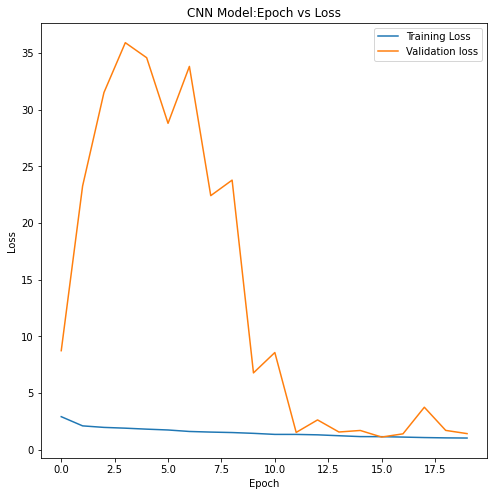

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)

plt.plot(history2.history['loss'], label="Training Loss")
plt.plot(history2.history['val_loss'], label="Validation loss")
plt.title('CNN Model:Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

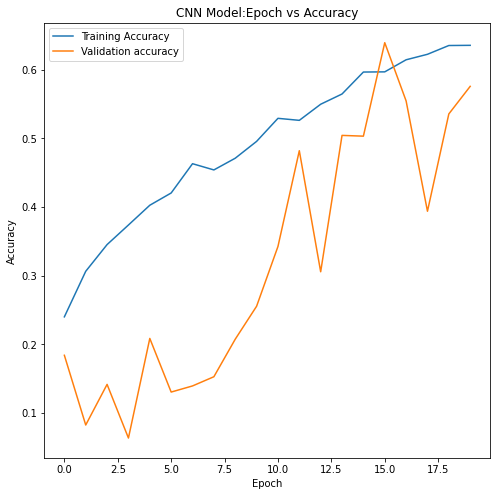

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)

plt.plot(history2.history['accuracy'], label="Training Accuracy")
plt.plot(history2.history['val_accuracy'], label="Validation accuracy")
plt.title('CNN Model:Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

## CNN Model Analysis

Analysis:
1. The model took some time initially to learn
2. The model training accuracy was as good as 60%
3. The model validation accuracy was as good as 60% as well
4. The model is not performing well with the current CNN architecture because of the low accuracy scores and poor performance in validation

# CNN Model with Transfer Learning : ResNet

In [ ]:
def normalize_data(img):
    
    #Normalize for ResNet50
    return tf.keras.applications.resnet50.preprocess_input(img)

In [ ]:
# Image generator used for train test split and data augmentation
train_img_generator= tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                               width_shift_range=0.2,
                                                               height_shift_range=0.2,                                                               
                                                               horizontal_flip=True,
                                                               validation_split=0.2,
                                                               preprocessing_function=normalize_data) #Normalize the data accordingly

# Image generator used for train test split and data augmentation
test_img_generator= tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2,
                                                                    preprocessing_function=normalize_data) #Normalize the data accordingly                                                              

In [ ]:
# Train data set
train_generator = train_img_generator.flow_from_directory(data_path,
                                                          target_size=(img_size, img_size),
                                                          batch_size=64,
                                                          subset='training')

# Test data set
validation_generator = test_img_generator.flow_from_directory(data_path,
                                                              target_size=(img_size, img_size),
                                                              batch_size=64,
                                                              subset='validation')

Found 3816 images belonging to 12 classes.
Found 951 images belonging to 12 classes.


## ResNet Model Building

In [ ]:
# Importing the ResNet model
tf.keras.backend.clear_session()
model_transfer = tf.keras.applications.ResNet50(include_top=False, #Do not include classification layer for imagenet
                                       input_shape=input_shape,
                                       weights='imagenet')

94781440/94765736 [==============================] - 1s 0us/step


In [ ]:
model_transfer.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
len(model_transfer.layers)

175

In [ ]:
#Set pre-trained model layers to not trainable
for layer in model_transfer.layers:
    layer.trainable = False

In [ ]:
model_transfer.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Since a model which is not at all trained gave abysmal results, we shall try training few of the last layers of CNN-Resnet

#Unfreezing all layers after layer 165 
for layer in model_transfer.layers[165:]:
    layer.trainable = True

In [ ]:
#Check if layers frozen
model_transfer.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
#get Output layer of Pre0trained model
x1 = model_transfer.output

#Global average pool to reduce number of features and Flatten the output
x2 = tf.keras.layers.GlobalAveragePooling2D()(x1)

In [ ]:
#Add output layer
prediction = tf.keras.layers.Dense(num_classes,activation='softmax')(x2)

In [ ]:
#Using Keras Model class
model_resnet = tf.keras.models.Model(inputs=model_transfer.input, #Pre-trained model input as input layer
                                    outputs=prediction) #Output layer added

## ResNet Model Summary and Compilation

In [ ]:
#Compile the model
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#How does our overall model looks
model_resnet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 32, 32, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Checkpoint

In [ ]:
#Saving the best model using model checkpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('plants_resnet.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

##Training the ResNet model

In [ ]:
#Lets train for 10 steps
history3 = model_resnet.fit(train_generator, 
                            epochs=20,
                            steps_per_epoch= 3816//64,
                            validation_data=validation_generator,
                            validation_steps = 951//64, 
                            callbacks=[model_checkpoint])

Epoch 1/20
59/59 [==============================] - 159s 3s/step - loss: 1.9350 - accuracy: 0.4123 - val_loss: 3.0322 - val_accuracy: 0.4308

Epoch 00001: val_accuracy improved from -inf to 0.43080, saving model to plants_resnet.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/20
59/59 [==============================] - 153s 3s/step - loss: 1.1622 - accuracy: 0.5943 - val_loss: 1.9877 - val_accuracy: 0.4955

Epoch 00002: val_accuracy improved from 0.43080 to 0.49554, saving model to plants_resnet.h5
Epoch 3/20
59/59 [==============================] - 154s 3s/step - loss: 1.0073 - accuracy: 0.6567 - val_loss: 1.6104 - val_accuracy: 0.5525

Epoch 00003: val_accuracy improved from 0.49554 to 0.55246, saving model to plants_resnet.h5
Epoch 4/20
59/59 [==============================] - 154s 3s/step - loss: 0.8984 - accuracy: 0.6791 - val_loss: 1.0233 - val_accuracy: 0.6350

Epoch 00004: val_accuracy improved from 0.55246 to 0.63504, saving model to plants_resnet.h5
Epoch 5/20
59/59 [==============================] - 155s 3s/step - loss: 0.8244 - accuracy: 0.7154 - val_loss: 1.0407 - val_accuracy: 0.6507

Epoch 00005: val_accuracy improved from 0.63504 to 0.65067, saving model to plants_resnet.h5
Epoch 6/20
59/59 [==============================] - 157s 3s/

## ResNet : Loss and Accuracy vs Epoch plotting

In [ ]:
print('Best validation ccuracy from Dense Model :', round(max(history3.history['accuracy'])*100,2))

Best validation ccuracy from Dense Model : 81.9


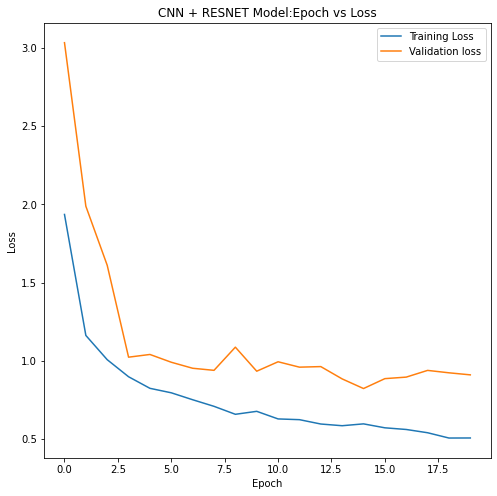

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)

plt.plot(history3.history['loss'], label="Training Loss")
plt.plot(history3.history['val_loss'], label="Validation loss")
plt.title('CNN + RESNET Model:Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

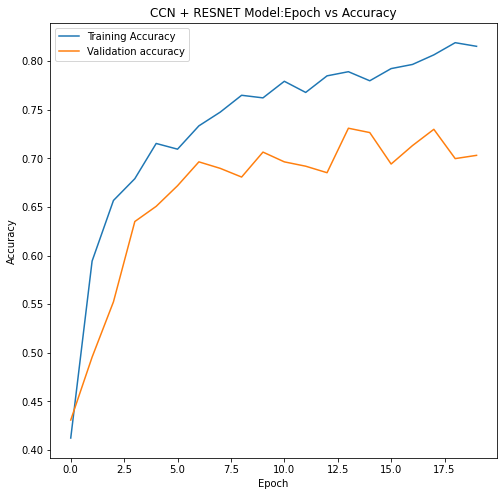

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)

plt.plot(history3.history['accuracy'], label="Training Accuracy")
plt.plot(history3.history['val_accuracy'], label="Validation accuracy")
plt.title('CCN + RESNET Model:Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

## ResNet Model Analysis

Analysis:
1. With transfer learning a good spike of accuracy of around 20% was observed.
2. Last 10 layers of a conventional ResNet50 were resued along with additonal dense layer for model training
3. By far the best model score for both validation and training , going as high as 72% and 80%  respectively.

# CNN Model with Tranfer Learning : VGG

In [ ]:
def normalize_data(img):
    
    #Normalize for ResNet50
    return tf.keras.applications.vgg16.preprocess_input(img)

In [ ]:
# Image generator used for train test split and data augmentation
train_img_generator= tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,
                                                               width_shift_range=0.2,
                                                               height_shift_range=0.2,                                                               
                                                               horizontal_flip=True,
                                                               validation_split=0.2,
                                                               preprocessing_function=normalize_data) #Normalize the data accordingly

# Image generator used for train test split and data augmentation
test_img_generator= tf.keras.preprocessing.image.ImageDataGenerator(validation_split=0.2,
                                                                    preprocessing_function=normalize_data) #Normalize the data accordingly                                                              

In [ ]:
# Train data set
train_generator = train_img_generator.flow_from_directory(data_path,
                                                          target_size=(img_size, img_size),
                                                          batch_size=64,
                                                          class_mode='categorical',
                                                          subset='training')

# Test data set
validation_generator = test_img_generator.flow_from_directory(data_path,
                                                              target_size=(img_size, img_size),
                                                              batch_size=64,
                                                              class_mode='categorical',
                                                              subset='validation')

Found 3816 images belonging to 12 classes.
Found 951 images belonging to 12 classes.


## VGG Model Building

In [ ]:
# Importing the ResNet model
tf.keras.backend.clear_session()
model_transfer = tf.keras.applications.VGG16(include_top=False, #Do not include classification layer for imagenet
                                       input_shape=input_shape,
                                       weights='imagenet')

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
model_transfer.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [ ]:
len(model_transfer.layers)

19

In [ ]:
#Set pre-trained model layers to not trainable
for layer in model_transfer.layers:
    layer.trainable = False

In [ ]:
model_transfer.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [ ]:
# Since a model which is not at all trained gave abysmal results, we shall try training few of the last layers of CNN-VGG

#Unfreezing all layers after layer 17 
for layer in model_transfer.layers[17:]:
    layer.trainable = True

In [ ]:
#Check if layers frozen
model_transfer.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [ ]:
#get Output layer of Pre0trained model
x1 = model_transfer.output

# Add a dense layer
x2 = tf.keras.layers.Dense(64)(x1)

#Global average pool to reduce number of features and Flatten the output
x3 = tf.keras.layers.GlobalAveragePooling2D()(x2)

In [ ]:
#Add output layer
prediction = tf.keras.layers.Dense(num_classes,activation='softmax')(x3)

In [ ]:
#Using Keras Model class
model_vgg = tf.keras.models.Model(inputs=model_transfer.input, #Pre-trained model input as input layer
                                    outputs=prediction) #Output layer added

## VGG Model Summary and Compilation

In [ ]:
#Compile the model
model_vgg.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#How does our overall model looks
model_vgg.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 64, 64, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

## Checkpoint

In [ ]:
#Saving the best model using model checkpoint callback
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('plants_vgg.h5', 
                                                    save_best_only=True, 
                                                    monitor='val_accuracy', 
                                                    mode='max', 
                                                    verbose=1)

## Training the VGG model

In [ ]:
#Lets train for 20 steps
history4 = model_vgg.fit(train_generator, 
                        epochs=20,
                        steps_per_epoch= 3816//64,
                        validation_data=validation_generator,
                        validation_steps = 951//64, 
                        callbacks=[model_checkpoint])

Epoch 1/20
59/59 [==============================] - 218s 4s/step - loss: 5.3235 - accuracy: 0.3009 - val_loss: 1.6132 - val_accuracy: 0.4565

Epoch 00001: val_accuracy improved from -inf to 0.45647, saving model to plants_vgg.h5
Epoch 2/20
59/59 [==============================] - 215s 4s/step - loss: 1.4674 - accuracy: 0.5029 - val_loss: 1.3675 - val_accuracy: 0.5223

Epoch 00002: val_accuracy improved from 0.45647 to 0.52232, saving model to plants_vgg.h5
Epoch 3/20
59/59 [==============================] - 221s 4s/step - loss: 1.2457 - accuracy: 0.5517 - val_loss: 1.1461 - val_accuracy: 0.6004

Epoch 00003: val_accuracy improved from 0.52232 to 0.60045, saving model to plants_vgg.h5
Epoch 4/20
59/59 [==============================] - 214s 4s/step - loss: 1.1514 - accuracy: 0.5928 - val_loss: 1.1628 - val_accuracy: 0.6004

Epoch 00004: val_accuracy did not improve from 0.60045
Epoch 5/20
59/59 [==============================] - 217s 4s/step - loss: 1.0648 - accuracy: 0.6277 - val_loss:

## VGG : Loss and Accuracy vs Epoch plot

In [ ]:
print('Best validation ccuracy from Dense Model :', round(max(history4.history['accuracy'])*100,2))

Best validation ccuracy from Dense Model : 73.45


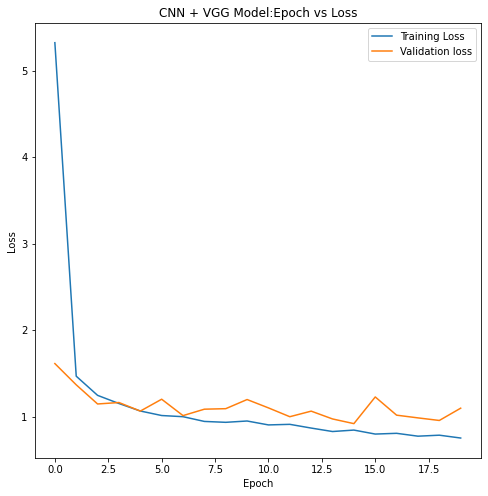

In [ ]:
plt.rcParams['figure.figsize'] = (8, 8)

plt.plot(history4.history['loss'], label="Training Loss")
plt.plot(history4.history['val_loss'], label="Validation loss")
plt.title('CNN + VGG Model:Epoch vs Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

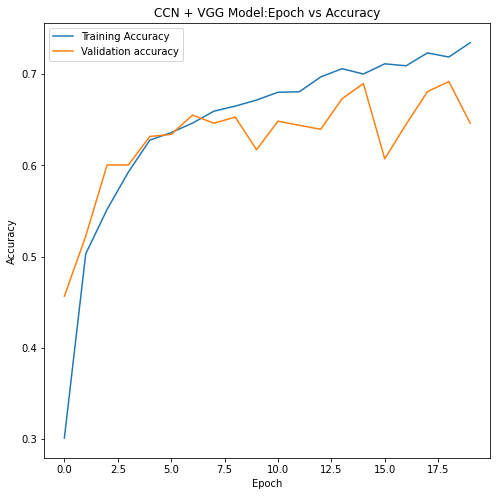

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)

plt.plot(history4.history['accuracy'], label="Training Accuracy")
plt.plot(history4.history['val_accuracy'], label="Validation accuracy")
plt.title('CCN + VGG Model:Epoch vs Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

## VGG Model Analysis

Analysis:
1. Custom VGG neural network perfformed better than a CNN because of the transfer learning advantage, but not as good as ResNet
2. We could achieve a training score of as high as 71%

# SVM Supervised Model for Image Classification

In [ ]:
plants = ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']
flat_data_arr=[]
target_arr=[]
data_path='/content/drive/MyDrive/AIML-Great Learning/Neural Network/Plants_photos/train'
for i in plants:
  path=os.path.join(data_path,i)
  for img in os.listdir(path):
    img_array=imread(os.path.join(path,img))
    img_resized=resize(img_array,(64,64,3))
    flat_data_arr.append(img_resized.flatten())
    target_arr.append(plants.index(i))
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data)
df['Target']=target
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,12249,12250,12251,12252,12253,12254,12255,12256,12257,12258,12259,12260,12261,12262,12263,12264,12265,12266,12267,12268,12269,12270,12271,12272,12273,12274,12275,12276,12277,12278,12279,12280,12281,12282,12283,12284,12285,12286,12287,Target
0,0.310539,0.196818,0.103064,0.354389,0.264794,0.186485,0.395221,0.321117,0.245872,0.386179,0.319512,0.238971,0.372128,0.302765,0.238304,0.418585,0.359965,0.308904,0.416544,0.355342,0.302696,0.385049,0.332223,0.273342,0.292099,0.229534,0.180457,0.302574,0.235957,0.180319,0.342731,0.266954,0.193792,0.338392,0.253274,0.178711,0.339311,0.256958,0.167620,0.370221,...,0.200000,0.200831,0.219608,0.208946,0.207843,0.219608,0.206495,0.204002,0.215686,0.203922,0.202328,0.215636,0.211642,0.205637,0.219363,0.200000,0.201781,0.207843,0.210172,0.206250,0.221936,0.220833,0.210336,0.228596,0.326348,0.319030,0.339706,0.521814,0.551225,0.574877,0.555760,0.583701,0.615074,0.520822,0.540196,0.568015,0.292651,0.285172,0.308582,0
1,0.411768,0.317650,0.186615,0.417428,0.326956,0.193622,0.425941,0.332498,0.199003,0.441061,0.346159,0.214051,0.466454,0.373454,0.243812,0.464920,0.372077,0.235117,0.489383,0.400066,0.253537,0.468249,0.374273,0.209501,0.449661,0.358489,0.193538,0.430362,0.338542,0.189554,0.402972,0.299011,0.173407,0.366191,0.262292,0.159596,0.359464,0.275732,0.189591,0.346430,...,0.274295,0.201245,0.118892,0.282039,0.181786,0.109490,0.299904,0.185202,0.129897,0.312374,0.199504,0.154374,0.318439,0.228029,0.184892,0.341466,0.285885,0.235278,0.362500,0.320365,0.257497,0.380938,0.343346,0.278977,0.388404,0.352435,0.291881,0.392256,0.350344,0.296116,0.362675,0.314221,0.257857,0.365936,0.310360,0.257363,0.366170,0.304771,0.257435,0
2,0.227451,0.158517,0.107537,0.227890,0.164706,0.118087,0.267096,0.200181,0.145527,0.326961,0.260294,0.199710,0.356863,0.287929,0.216022,0.367813,0.302206,0.234479,0.332603,0.265936,0.205142,0.282353,0.215686,0.158386,0.316667,0.253248,0.195098,0.335636,0.265048,0.194424,0.345711,0.265331,0.186581,0.326103,0.245404,0.163051,0.296385,0.229718,0.157890,0.272855,...,0.626546,0.627451,0.627451,0.623529,0.627451,0.631373,0.619608,0.626900,0.627451,0.560968,0.560968,0.560968,0.323201,0.307904,0.307904,0.392218,0.384375,0.384375,0.500061,0.492218,0.492218,0.541771,0.533333,0.533333,0.536794,0.530730,0.528615,0.513619,0.509620,0.505699,0.486275,0.474510,0.467096,0.453687,0.444179,0.439216,0.423529,0.415686,0.412721,0
3,0.231618,0.195217,0.171687,0.278665,0.223518,0.195577,0.379883,0.318260,0.253657,0.419485,0.353922,0.269485,0.368819,0.289583,0.208088,0.371243,0.302738,0.218302,0.330587,0.244681,0.179657,0.296201,0.203922,0.137255,0.339828,0.259256,0.166912,0.367034,0.280932,0.176716,0.346814,0.272591,0.185459,0.312466,0.261029,0.203064,0.283088,0.226348,0.167525,0.229883,...,0.365292,0.266272,0.166395,0.334402,0.231985,0.133735,0.317076,0.234436,0.152003,0.329167,0.262328,0.185784,0.327328,0.260662,0.205695,0.335114,0.266667,0.213603,0.337623,0.266471,0.201471,0.379860,0.276961,0.179822,0.400980,0.280848,0.163603,0.381127,0.258307,0.139924,0.369344,0.275368,0.193156,0.370711,0.304791,0.238971,0.368627,0.305021,0.242276,0
4,0.654902,0.658245,0.663323,0.647763,0.651685,0.657721,0.651685,0.654902,0.667371,0.651685,0.655607,0.667371,0.651250,0.655607,0.663450,0.650980,0.650980,0.659512,0.659528,0.659528,0.667371,0.655607,0.656587,0.667371,0.647763,0.650980,0.658824,0.655607,0.659528,0.659528,0.655607,0.659528,0.665938,0.659528,0.659528,0.671293,0.655607,0.661112,0.671293,0.651685,...,0.247059,0.207485,0.177175,0.237623,0.176103,0.137592,0.253652,0.160784,0.101937,0.244056,0.153233,0.096446,0.226042,0.137255,0.086275,0.201807,0.135355,0.094822,0.171608,0.119547,0.094118,0.208715,0.161656,0.121661,0.247059,0.192862,0.137690,0.212253,0.147120,0.102972,0.188235,0.124857,0.089491,0.192935,0.135141,0.092004,0.220837,0.167923,0.120864,0
...,...,...,...,...,...,...,...,...,...,...,...,.

In [ ]:
x=df.iloc[:,:-1]
y=df.iloc[:,-1]
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=77,stratify=y)

In [74]:
# param_grid={'C':[0.1,1,10],'gamma':[0.001,0.1,1],'kernel':['rbf','poly']}
# svc=svm.SVC(probability=True)
clf = svm.SVC(gamma=0.001, C=10.0, probability=True, kernel='rbf', random_state=777)
clf.fit(x_train,y_train)

SVC(C=10.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=True, random_state=777, shrinking=True, tol=0.001,
    verbose=False)

In [75]:
y_pred=clf.predict(x_test)
print("The predicted Data is :")
y_pred

The predicted Data is :


array([ 1, 11,  1, 10, 11,  2,  6,  1,  9,  3,  1,  5, 11,  6, 10,  8,  2,
        1, 10,  0, 10,  6, 10,  0,  3,  5,  1,  7,  3,  1,  5,  6, 11,  6,
       10,  2,  6,  5,  1,  2,  2,  0,  3, 10,  2,  7,  3,  6,  8, 10, 10,
       10,  0,  8, 10,  8,  3,  5,  4,  8,  5,  2,  3,  5,  3,  0,  3,  1,
        3,  0,  8,  7, 11,  6, 10,  8, 10,  9, 10,  6,  6,  2,  2,  8,  6,
        1,  6,  6, 11,  1,  5, 10,  3, 10,  1, 10,  3,  1, 11,  6,  6,  3,
        1,  6,  8,  2,  2,  6,  6, 11,  1, 10,  3,  8,  8,  6, 10,  1,  0,
        9,  3,  0, 11,  8,  8,  6,  0,  5,  6,  3,  4,  6,  5,  5, 11,  3,
       11,  6,  3,  2,  3, 10, 11,  1, 10,  8,  5,  6,  3,  3,  6,  3,  6,
        8,  3,  8,  1,  1,  8,  0, 11, 10, 10,  3,  0, 11, 10, 11, 10,  3,
        1,  3,  8,  1,  6,  6,  6, 11,  2,  4,  8,  6, 11, 10,  9,  6, 10,
        8,  8,  8, 10,  8,  8,  6,  6,  1,  8,  8,  3, 10,  8,  5,  6,  3,
        6,  3,  0,  3, 11,  3,  8,  0,  3,  3,  8,  1,  4,  1,  8,  8,  2,
        3,  5,  8,  6,  5

In [ ]:
print("The actual data is:")
np.array(y_test)

In [77]:
#classification_report(y_pred,y_test)
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")
confusion_matrix(y_pred,y_test)

The model is 57.54716981132076% accurate


array([[  8,   0,   0,   0,   5,   2,  12,   0,   3,   0,   0,   4],
       [  0,  56,   3,   3,   0,   1,   0,   5,   9,   3,   7,   1],
       [  0,   5,  44,   1,   5,   2,   0,   0,   3,   1,   2,   2],
       [  1,   4,   1,  80,   0,   4,   1,  11,  15,  11,   5,   4],
       [  4,   1,   2,   0,   9,   5,   4,   0,   1,   0,   0,   3],
       [  3,   1,   1,  10,   6,  47,   6,   1,   1,   0,   4,  10],
       [ 34,   0,   1,   1,  12,  17, 109,   2,   1,   0,   2,   7],
       [  0,   0,   0,   1,   0,   2,   0,  20,   0,   1,   1,   1],
       [  1,   1,   1,  19,   3,   5,   1,   3,  57,  12,   0,   6],
       [  0,   2,   0,   4,   0,   0,   0,   1,   3,  11,   3,   0],
       [  1,   6,   1,   3,   0,   4,   0,   0,   0,   6,  74,   5],
       [  1,   2,   4,   0,   4,   6,   2,   1,  10,   1,   1,  34]])

## SVM Model Analysis

Analysis:
1. The model took a lot of time to train and eventually exhausted and stopped while trying gridsearch
2. With simple SVM , the accuracy is as low as 57% and is not the best score so far

# Prediction on test image

In [84]:
img_path = '/content/drive/MyDrive/AIML-Great Learning/Neural Network/Plants_photos/predict_plant.png'

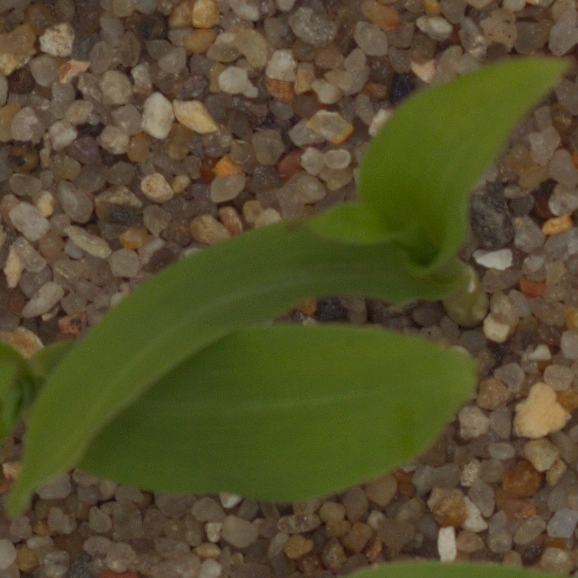

In [87]:
predict_image = tf.keras.preprocessing.image.load_img(img_path)
predict_image

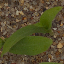

In [85]:
img = tf.keras.preprocessing.image.load_img(img_path, target_size=(64, 64))
img

In [80]:
x = tf.keras.preprocessing.image.img_to_array(img)

print(x.shape)
x = np.expand_dims(x, axis=0)
print(x.shape)
x=normalize_data(x)
x.shape

(64, 64, 3)
(1, 64, 64, 3)


(1, 64, 64, 3)

In [81]:
train_generator.class_indices

{'Black-grass': 0,
 'Charlock': 1,
 'Cleavers': 2,
 'Common Chickweed': 3,
 'Common wheat': 4,
 'Fat Hen': 5,
 'Loose Silky-bent': 6,
 'Maize': 7,
 'Scentless Mayweed': 8,
 'Shepherds Purse': 9,
 'Small-flowered Cranesbill': 10,
 'Sugar beet': 11}

In [82]:
from keras.models import load_model
Best_model = load_model('plants_resnet.h5') 

In [83]:
features = Best_model.predict(x)
print( "Actual class is: ",np.argmax(features))

Actual class is:  7


## **Prediction is class 7 and it corresponds to 'Maize' species of plant seedling**